<a href="https://colab.research.google.com/github/Natasha617/-advanced-machine-learning/blob/main/%D0%A1%D0%BE%D1%80%D0%B5%D0%B2%D0%BD%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание

Кто там? Предскажите, кто вошел в здание по времени и турникету. Мы знаем, что "след" через турникеты принадлежит "Х". Кто этот "Х" предстоит вычислить по данным, которые нам известны. А ID юзеров известны по обучающей выборке (кроме нескольких новых!).

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить “таблетку”. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить кому конкретно принадлежит след прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько - не больше 10% - новых).

“8 утра понедельник, турникет 4? Директор.” “11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.”  Какие есть паттерны в настоящих данных?

В тестовой выборке id посетителей заменены на слова: aucroc, binary, blue, categorical и т.п.

Ваша задача - составить таблицу вида:

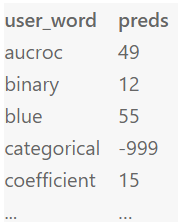

где user_word - index, preds - колонка с соответствующими id. Таблицу нужно запомнить как csv и потом заархивировать в zip архив (см. пример csv файла в секции Data). -999 – id нового посетителя, которого раньше не было.

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать id. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее вы отгадали слово, тем больше баллов.

# Библиотеки

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/шифт/train.csv' /content/data_train.csv
!cp '/content/drive/MyDrive/шифт/test.csv' /content/data_test.csv

In [ ]:
train = pd.read_csv('data_train.csv', index_col=0)
test = pd.read_csv('data_test.csv', index_col=0)

In [ ]:
train.tail()

,user_id,ts,gate_id
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9
37517,6,2022-12-31 20:39:31,9


In [ ]:
test.head()

,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini


In [ ]:
train['user_id'].value_counts()

37    2262
55    2238
6     2013
12    1953
19    1793
15    1756
18    1578
47    1341
53    1311
1     1299
33    1285
11    1281
49    1275
0     1250
39    1144
32    1076
54    1070
9     1034
50     994
29     990
3      989
48     743
14     696
17     677
27     603
35     601
46     502
57     497
24     416
42     359
26     316
34     284
23     261
25     247
40     242
31     191
56     137
41     124
43     124
20     115
22      96
28      64
45      57
7       49
36      48
2       39
8       29
10      17
38      13
5       10
30      10
52       5
21       5
44       4
51       3
4        2
Name: user_id, dtype: int64

Можно увидеть, что классы несбалансированны

# Обработка данных

Попробую удалить дубликаты в тернировочных, а потом в тестовых данных

сначала объединяю все в один датасет

In [ ]:
all_data = pd.concat([train, test], axis=0)

In [ ]:
all_data

,user_id,ts,gate_id,user_word
0,18.0,2022-07-29 09:08:54,7,NaN
1,18.0,2022-07-29 09:09:54,9,NaN
2,18.0,2022-07-29 09:09:54,9,NaN
3,18.0,2022-07-29 09:10:06,5,NaN
4,18.0,2022-07-29 09:10:08,5,NaN
...,...,...,...,...
44638,NaN,2023-02-24 19:43:36,11,collinear
44639,NaN,2023-02-24 19:44:00,4,collinear
44640,NaN,2023-02-24 19:44:01,4,collinear
44641,NaN,2023-02-24 19:44:09,9,collinear


In [ ]:
all_data = all_data.drop_duplicates(keep='first')

удалилось какое-то количество дубликатов


In [ ]:
pd.to_datetime(all_data['ts'])

0       2022-07-29 09:08:54
1       2022-07-29 09:09:54
3       2022-07-29 09:10:06
4       2022-07-29 09:10:08
5       2022-07-29 09:10:34
                ...        
44637   2023-02-24 17:08:57
44638   2023-02-24 19:43:36
44639   2023-02-24 19:44:00
44640   2023-02-24 19:44:01
44641   2023-02-24 19:44:09
Name: ts, Length: 41792, dtype: datetime64[ns]

In [ ]:
# Список дней недели
all_data['ts'] = pd.to_datetime(all_data['ts'])
list_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

all_data[list_dow] = pd.get_dummies(all_data['ts'].dt.day_name())[list_dow].values

<ipython-input-12-7cbe156aa16b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['ts'] = pd.to_datetime(all_data['ts'])
<ipython-input-12-7cbe156aa16b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[list_dow] = pd.get_dummies(all_data['ts'].dt.day_name())[list_dow].values
<ipython-input-12-7cbe156aa16b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [ ]:
all_data['hour'] = all_data['ts'].dt.hour.values

<ipython-input-13-5409472620e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['hour'] = all_data['ts'].dt.hour.values


In [ ]:
# Список переменных вида "hour_час в полной выборке"

list_hours = ['hour_'+str(i) for i in sorted(list(all_data['ts'].dt.hour.unique()))]

In [ ]:
all_data[list_hours] = pd.get_dummies(all_data['ts'].dt.hour.values).values

<ipython-input-15-ac43479422ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[list_hours] = pd.get_dummies(all_data['ts'].dt.hour.values).values
<ipython-input-15-ac43479422ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[list_hours] = pd.get_dummies(all_data['ts'].dt.hour.values).values
<ipython-input-15-ac43479422ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:
all_data['min'] = all_data['ts'].dt.minute.values
all_data['day'] = all_data['ts'].dt.day.values
all_data['month'] = all_data['ts'].dt.month.values
all_data['dayofweek'] = all_data['ts'].dt.dayofweek.values

<ipython-input-16-0c91241cd7c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['min'] = all_data['ts'].dt.minute.values
<ipython-input-16-0c91241cd7c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['day'] = all_data['ts'].dt.day.values
<ipython-input-16-0c91241cd7c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
all_gates = sorted(list(all_data['gate_id'].unique()))
all_gates

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
# Составим список турникетов вида "gate_номер"

list_gate_vars = ['gate_'+str(i) for i in all_gates]

# Теперь: cделаем бинарные переменные

new_vals = pd.get_dummies(all_data['gate_id']).values

# Припишем новые бинарные переменные "турникет" к полной выборке

all_data[list_gate_vars] = new_vals

<ipython-input-18-b50f610571ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[list_gate_vars] = new_vals
<ipython-input-18-b50f610571ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[list_gate_vars] = new_vals
<ipython-input-18-b50f610571ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [ ]:
all_data['day']

0        29
1        29
3        29
4        29
5        29
         ..
44637    24
44638    24
44639    24
44640    24
44641    24
Name: day, Length: 41792, dtype: int64

In [ ]:
all_data.columns

Index(['user_id', 'ts', 'gate_id', 'user_word', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour',
       'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'min', 'day', 'month', 'dayofweek', 'gate_-1',
       'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6',
       'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12',
       'gate_13', 'gate_14', 'gate_15', 'gate_16'],
      dtype='object')

# Далее можно попробовать Случайный андерсэмплинг и оверсэмплинг

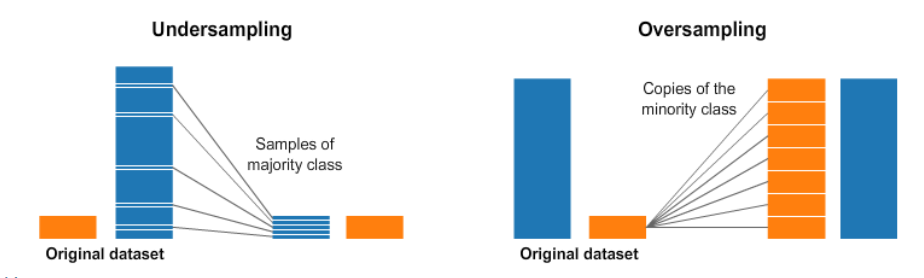

In [ ]:
train_idx = all_data['user_word'].isnull()
train = all_data.loc[train_idx]
test = all_data.loc[~train_idx]

In [ ]:
train['user_id'] = train['user_id'].astype(int)

<ipython-input-22-8bf65ea568aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['user_id'] = train['user_id'].astype(int)


In [ ]:
train = train[(train['user_id'] != 4) & (train['user_id'] != 51) & (train['user_id'] != 44) & (train['user_id'] != 21) & (train['user_id'] != 52)]

просто создала копию обучающего датасета без лишних колонок

In [ ]:
train_features = train.drop(columns = [ 'ts', 'gate_id', 'user_word']).copy()

In [ ]:
train['user_id'].value_counts()

37    2184
55    2166
6     1857
12    1837
19    1661
15    1659
18    1441
53    1279
11    1255
47    1250
33    1184
0     1184
1     1171
49    1129
39    1032
32    1020
9     1015
54     977
50     965
29     924
3      894
48     712
17     648
14     617
35     549
27     523
57     482
46     475
24     386
42     340
26     279
34     267
23     247
40     242
25     238
31     181
56     129
43     117
20     112
41     110
22      87
28      64
45      57
7       48
36      45
2       39
8       27
10      17
38      13
5       10
30      10
Name: user_id, dtype: int64

In [ ]:
test_features = test.drop(columns = [ 'ts', 'gate_id', 'user_word','user_id']).copy()

# train_test_split

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(train_features.drop(columns = 'user_id'), train_features['user_id'], test_size=0.2, random_state=12)

# SMOTE

In [ ]:
sm = SMOTE(random_state=12, k_neighbors = 8)
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

In [ ]:
x_train_smote

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,hour,hour_0,hour_1,...,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16
0,0,1,0,0,0,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,11,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88582,0,0,1,0,0,0,0,14,0,0,...,0,0,0,0,0,0,0,0,0,0
88583,1,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
88584,0,0,0,0,0,0,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
88585,0,0,0,0,0,0,0,15,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train_smote

0        54
1         6
2        55
3        19
4        55
         ..
88582    57
88583    57
88584    57
88585    57
88586    57
Name: user_id, Length: 88587, dtype: int64

In [ ]:
test

,user_id,ts,gate_id,user_word,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,...,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16
37518,NaN,2023-01-03 08:21:00,9,gini,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
37520,NaN,2023-01-03 08:21:18,5,gini,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37521,NaN,2023-01-03 08:21:19,5,gini,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37522,NaN,2023-01-03 08:21:39,10,gini,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
37523,NaN,2023-01-03 08:32:49,15,epsilon,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44637,NaN,2023-02-24 17:08:57,10,collinear,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
44638,NaN,2023-02-24 19:43:36,11,collinear,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
44639,NaN,2023-02-24 19:44:00,4,collinear,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
44640,NaN,2023-02-24 19:44:01,4,collinear,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.head()

,user_id,ts,gate_id,user_word,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,...,gate_7,gate_8,gate_9,gate_10,gate_11,gate_12,gate_13,gate_14,gate_15,gate_16
0,18,2022-07-29 09:08:54,7,NaN,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,18,2022-07-29 09:09:54,9,NaN,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,18,2022-07-29 09:10:06,5,NaN,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,18,2022-07-29 09:10:08,5,NaN,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,18,2022-07-29 09:10:34,10,NaN,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


# Scaler

In [ ]:
scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

scaler_X.fit(x_train_smote)
scaler_X_test.fit(x_test)

X_scaled = scaler_X.transform(x_train_smote)
X_test_scaled = scaler_X_test.transform(x_test)

In [ ]:
X_scaled

array([[-0.49015093, -0.466589  , -0.48559774, ..., -0.00577225,
        -0.09034548, -0.00816333],
       [-0.49015093,  2.14321386, -0.48559774, ..., -0.00577225,
        -0.09034548, -0.00816333],
       [ 2.04018791, -0.466589  , -0.48559774, ..., -0.00577225,
        -0.09034548, -0.00816333],
       ...,
       [-0.49015093, -0.466589  ,  2.05931766, ..., -0.00577225,
        -0.09034548, -0.00816333],
       [-0.49015093, -0.466589  , -0.48559774, ..., -0.00577225,
        -0.09034548, -0.00816333],
       [-0.49015093,  2.14321386, -0.48559774, ..., -0.00577225,
        -0.09034548, -0.00816333]])

In [ ]:
len(y_train)

30014

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5,weights = 'distance',algorithm = 'ball_tree').fit(X_scaled,y_train_smote)

In [ ]:
f1_score(y_test, neigh.predict(X_test_scaled), average='weighted')

0.13802087255073595

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1,weights = 'uniform',algorithm = 'brute').fit(x_train, y_train)

The 'metric' parameter of KNeighborsClassifier must be a str among {'minkowski', 'dice', 'nan_euclidean', 'cityblock', 'yule', 'euclidean', 'russellrao', 'wminkowski', 'precomputed', 'canberra', 'kulsinski', 'hamming', 'matching', 'haversine', 'seuclidean', 'infinity', 'l1', 'l2', 'correlation', 'manhattan', 'sqeuclidean', 'pyfunc', 'chebyshev', 'sokalsneath', 'sokalmichener', 'cosine', 'rogerstanimoto', 'mahalanobis', 'p', 'braycurtis', 'jaccard'}

In [ ]:
f1_score(y_test, neigh.predict(x_test), average='weighted')

0.7583334568720267

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC().fit(X_scaled,y_train_smote)

In [ ]:
f1_score(y_test, svc.predict(X_test_scaled), average='weighted')

0.1439785068153389

# сохранение

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5,weights = 'uniform',algorithm = 'brute').fit(train_features.drop(columns = 'user_id'), train_features['user_id'])

In [ ]:
clf2 = RandomForestClassifier(random_state=42).fit(train_features.drop(columns = 'user_id'), train_features['user_id'])

In [ ]:
preds = clf2.predict(test_features)
answer = pd.DataFrame()
answer['word'] = test['user_word']
answer['preds'] = preds
users = list(answer['word'].unique())
answer_uniq = pd.DataFrame()
answer_uniq['word'] = users
answer_uniq['preds'] = 0

for i in range(len(answer_uniq)):
  answer_uniq.iloc[i,1] = answer[answer['word']== answer_uniq.iloc[i,0]].value_counts().index[0][1]

answer_uniq.set_index('word', inplace=True)
answer_uniq.to_csv('answer.csv')

In [ ]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=9297370fae7f477001a4335b4bca303c57334482fddef85834b99e5db2252847
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
import session_info
session_info.show()

In [ ]:
answer_uniq

,preds
word,
gini,3
epsilon,1
fit,18
recall,39
linear,53
target,47
significant,15
ols,18
f1,19


# GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB().fit(x_train, y_train)

In [ ]:
f1_score(y_test, gnb.predict(x_test), average = 'weighted')

0.037532848670594934

# RandomForest

In [ ]:
clf1 = RandomForestClassifier(random_state=42).fit(X_scaled,y_train_smote)

y_pred = clf1.predict(x_train)

y_test_pred = clf1.predict(x_test)

f1_score(y_test, y_test_pred, average='weighted')

0.5474940687026124

### RandomForestClassifier + StandartScaler

In [ ]:
clf2 = RandomForestClassifier(random_state=42).fit(X_scaled,y_train_smote)



f1_score(y_test, clf2.predict(X_test_scaled), average='weighted')

0.49276986605049217

## Гиперпараметры для RandomForest

In [ ]:
clf3 = RandomForestClassifier()

In [ ]:
"""grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

grid = GridSearchCV(clf3,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(x_train,y_train)

print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))"""

# BaggingClassifier

In [ ]:
bagg = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
  random_state=21).fit(x_train,y_train)

ValueError: Found input variables with inconsistent numbers of samples: [30014, 37518]

In [ ]:
f1_score(y_test, bagg.predict(x_test), average='weighted')

0.5339869666066228

# BaggingClassifier + StandartScaler

In [ ]:
bagg = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
  random_state=21).fit(X_scaled, y_train)
f1_score(y_test, bagg.predict(X_test_scaled), average='weighted')

0.5367080864376659

# GradientBoostingClassifier+ StandartScaler

In [ ]:
boost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=42, max_depth=2).fit(X_scaled,y_train)

In [ ]:
f1_score(y_test, boost.predict(X_test_scaled), average='weighted')

0.016166098643799396

# AdaBoostClassifier + StandartScaler


    (base_estimator=DecisionTreeClassifier(max_depth=80, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=21) - score 0.6950

     (max_depth=90, class_weight='balanced'),
    n_estimators=400,
    learning_rate=0.8,
    random_state=42) ---

In [ ]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=90, class_weight='balanced'),
    n_estimators=400,
    learning_rate=0.3,
    random_state=42)

In [ ]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=90, class_weight='balanced'),
    n_estimators=400,
    learning_rate=0.3,
    random_state=42).fit(X_scaled,y_train)
f1_score(y_test, ada.predict(X_test_scaled), average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6958221649107792

### обучение на всем датасете

In [ ]:
data_train = train.drop(columns = ['user_id',	'ts',	'gate_id',	'user_word'])
data_test = test.drop(columns = ['user_id',	'ts',	'gate_id',	'user_word'])

scaler_train = StandardScaler()
scaler_test = StandardScaler()

scaler_train.fit(data_train)
scaler_test.fit(data_test)

train_scaled = scaler_train.transform(data_train)
test_scaled = scaler_test.transform(data_test)
y = train['user_id']

In [ ]:
ada = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=90, class_weight='balanced'),
    n_estimators=400,
    learning_rate=0.3,
    random_state=42).fit(train_scaled,y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
preds = ada.predict(test_scaled)

In [ ]:
answer_ada = pd.DataFrame()
answer_ada['word'] = test['user_word']
answer_ada['preds'] = preds

In [ ]:
users = list(answer_ada['word'].unique())
answer_uniq_ada = pd.DataFrame()
answer_uniq_ada['word'] = users
answer_uniq_ada['preds'] = 0

In [ ]:
for i in range(len(answer_uniq_ada)):
  answer_uniq_ada.iloc[i,1] = answer_ada[answer_ada['word']== answer_uniq_ada.iloc[i,0]].value_counts().index[0][1]

In [ ]:
answer_uniq_ada

In [ ]:
answer_uniq_ada.set_index('word', inplace=True)

In [ ]:
answer_uniq_ada.to_csv('answer.csv')

скор в таблице меньше, чем у рандом форест((

# StackingClassifier + StandartScaler

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()

In [ ]:
tree = DecisionTreeClassifier(max_depth=120)
rand = RandomForestClassifier()


In [ ]:
stack = StackingClassifier(estimators= [('knn',neigh),('tree',tree),('RandF',rand)], final_estimator=log).fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [ ]:
rand.fit(X_scaled,y_train_smote)

RandomForestClassifier()

In [ ]:
(X_test_scaled).shape

(7504, 51)

In [ ]:
f1_score(y_test, stack.predict(x_test), average='weighted')

0.7586316287866058

# сохранение

In [ ]:
stack = StackingClassifier(estimators= [('knn',neigh),('tree',tree),('RandF',rand)], final_estimator=log).fit(train_features.drop(columns = 'user_id'), train_features['user_id'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [ ]:
preds = stack.predict(test_features)
answer = pd.DataFrame()
answer['word'] = test['user_word']
answer['preds'] = preds
users = list(answer['word'].unique())
answer_uniq = pd.DataFrame()
answer_uniq['word'] = users
answer_uniq['preds'] = 0

for i in range(len(answer_uniq)):
  answer_uniq.iloc[i,1] = answer[answer['word']== answer_uniq.iloc[i,0]].value_counts().index[0][1]

answer_uniq.set_index('word', inplace=True)
answer_uniq.to_csv('answer.csv')

In [ ]:
answer_uniq

,preds
word,
gini,18
epsilon,18
fit,18
recall,18
linear,55
target,55
significant,55
ols,37
f1,18


In [ ]:
f1_score(y_test, stack.predict(X_test_scaled), average='weighted')

0.5819966001363033

In [ ]:
tree.fit(X_scaled,y_train_smote)

DecisionTreeClassifier(max_depth=150)

In [ ]:
f1_score(y_test, tree.predict(X_test_scaled), average='weighted')

0.5745419544582346

In [ ]:
pred = stack.predict_proba(X_test_scaled)

In [ ]:
test

In [ ]:
ver_df = pd.D

In [ ]:
y_train.unique()[46]

45

In [ ]:
pred[0]

array([0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.02, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.04, 0.03, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.78, 0.  , 0.05, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  ,
       0.  ])

In [ ]:
stack.predict(X_test_scaled)[0]

48

In [ ]:
pred[0]

In [ ]:
import numpy as np
np.argmax(pred[0])

46

In [ ]:
stack.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57])

### обучение на всем датасете

In [ ]:
train_features
sm = SMOTE(random_state=12, k_neighbors = 1)
all_x_train_smote, all_y_train_smote = sm.fit_resample(train_features.drop(columns = 'user_id'), train_features['user_id'])

In [ ]:
data_train = all_x_train_smote
data_test = test.drop(columns = ['user_id',	'ts',	'gate_id',	'user_word'])

scaler_train = StandardScaler()
scaler_test = StandardScaler()

scaler_train.fit(data_train)
scaler_test.fit(data_test)

train_scaled = scaler_train.transform(data_train)
test_scaled = scaler_test.transform(data_test)
y = all_y_train_smote

In [ ]:
stack = StackingClassifier(estimators= [('DecisionTree',tree),('RandF',rand)], final_estimator=rand).fit(train_scaled,y)

In [ ]:
test_scaled.shape

(7125, 51)

In [ ]:
train_scaled.shape

(126672, 51)

In [ ]:
preds = stack.predict(test_scaled)
answer = pd.DataFrame()
answer['word'] = test['user_word']
answer['preds'] = preds
users = list(answer['word'].unique())
answer_uniq = pd.DataFrame()
answer_uniq['word'] = users
answer_uniq['preds'] = 0

for i in range(len(answer_uniq)):
  answer_uniq.iloc[i,1] = answer[answer['word']== answer_uniq.iloc[i,0]].value_counts().index[0][1]

answer_uniq.set_index('word', inplace=True)
answer_uniq.to_csv('answer.csv')

# DecisionTreeClassifier на всех данных

Данные с другой обработкой

в тесте не было столбца юзер айди и добавила из старыхданных

In [ ]:
!cp '/content/drive/MyDrive/шифт/test.csv' /content/old_test.csv

In [ ]:
!cp '/content/drive/MyDrive/шифт/new_train.csv' /content/data_train.csv
!cp '/content/drive/MyDrive/шифт/new_test.csv' /content/data_test.csv

In [ ]:
train = pd.read_csv('data_train.csv', index_col=0)
test = pd.read_csv('data_test.csv', index_col=0)

In [ ]:
old_test = pd.read_csv('old_test.csv', index_col=0)

In [ ]:
test

,Min,Day,Day_Name_Monday,Day_Name_Saturday,Day_Name_Sunday,Day_Name_Thursday,Day_Name_Tuesday,Day_Name_Wednesday,gate_id_0,gate_id_1,...,gate_id_8,gate_id_9,gate_id_10,gate_id_11,gate_id_12,gate_id_13,gate_id_14,gate_id_15,gate_id_16,preds
Hour,,,,,,,,,,,,,,,,,,,,,
8.0,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8.0,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8.0,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8.0,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8.0,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.0,43.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0
19.0,44.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
19.0,44.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


In [ ]:
tree = DecisionTreeClassifier(max_depth=150).fit(train.drop(columns = 'user_id'), train['user_id'])

In [ ]:
preds = tree.predict(test.drop(columns='preds'))
answer = pd.DataFrame()
answer['word'] = old_test['user_word']
answer['preds'] = preds
users = list(answer['word'].unique())
answer_uniq = pd.DataFrame()
answer_uniq['word'] = users
answer_uniq['preds'] = 0

for i in range(len(answer_uniq)):
  answer_uniq.iloc[i,1] = answer[answer['word']== answer_uniq.iloc[i,0]].value_counts().index[0][1]

answer_uniq.set_index('word', inplace=True)
answer_uniq.to_csv('answer.csv')

In [ ]:
clf2 = RandomForestClassifier(random_state=42).fit(train_scaled, y_train)

y_pred = clf2.predict(test_scaled)

In [ ]:
users = list(answer['word'].unique())

In [ ]:
answer_uniq = pd.DataFrame()
answer_uniq['word'] = users
answer_uniq['preds'] = 0

In [ ]:
for i in range(len(answer_uniq)):
  answer_uniq.iloc[i,1] = answer[answer['word']== answer_uniq.iloc[i,0]].value_counts().index[0][1]

In [ ]:
answer_uniq.set_index('word', inplace=True)

In [ ]:
answer_uniq.to_csv('answer.csv')

In [ ]:
tree = DecisionTreeClassifier(max_depth=150).fit(train_scaled, y)

In [ ]:
preds =

# Обучение с немного другой обработкой


In [ ]:
train

,Min,Day,Day_Name_Monday,Day_Name_Saturday,Day_Name_Sunday,Day_Name_Thursday,Day_Name_Tuesday,Day_Name_Wednesday,gate_id_0,gate_id_1,...,gate_id_8,gate_id_9,gate_id_10,gate_id_11,gate_id_12,gate_id_13,gate_id_14,gate_id_15,gate_id_16,user_id
Hour,,,,,,,,,,,,,,,,,,,,,
9.0,8.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
9.0,9.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
9.0,9.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
9.0,10.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
9.0,10.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20.0,38.0,31.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0
20.0,39.0,31.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
20.0,39.0,31.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
